# Functional Data Analysis with Monovariate Prediction
This notebook demonstrates the process of conducting a functional data analysis with a focus on monovariate prediction. It outlines the goal of the notebook, the dataset being used, and the main steps that will be taken.

## Setting Up the Environment
The following cells set up the environment by loading necessary libraries and defining the path to the simulation file.

In [28]:
# @__DIR__ is the directory of the current file
# We need to go up to the parent directory to find the project root
project_root = dirname(dirname(@__DIR__))


include(joinpath(project_root, "setup", "init_env.jl"))
set_R_lib_path(project_root)

  Activating project at `c:\Users\User\Documents\repos\TESI\tesi_data\progetto_s_on_f.md\b_spline\functional-data-regression-mip`


RObject{StrSxp}
[1] "C:/Users/User/AppData/Local/R/cache/R/renv/library/functional-data-regression-mip-e3349204/R-4.3/x86_64-w64-mingw32"
[2] "C:/Users/User/AppData/Local/R/win-library/4.3"                                                                      
[3] "C:/Program Files/R/R-4.3.1/library"                                                                                 


## Load Data and Run R Simulation
Here we load the data required for the simulation and run the R simulation script to prepare the data for analysis.

**NOTICE** -> The seed should be the same for both the training and the test datasets, otherwise the data distribution will be different. 
This is very important specifically in the "Paper simulation" where the predictors shape depends on the coefficients a1,...f3 extracted from Uniform and Normal distributions.  

In [29]:
include(joinpath(project_root, "src", "Julia", "utils", "simulation.jl"))


simulation_name = "3_predictors"
simulation_settings_file = "intercept"

params_train = (
    # observations = 100,
    # measurements = 200,
    # basis_functions = 5,
    noise_snr = [100,100],
    # seed = 1
)

params_test = (
    # observations = 100,
    # measurements = 50,
    # basis_functions = 6,
    # # error_sd = 0.0,
    # seed = 12
)

# Note: Use ... to unpack NamedTuple into keyword arguments
output = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_train...)

output_test = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_test...)




OrderedCollections.OrderedDict{Symbol, Any} with 23 entries:
  :predictors        => 3.0
  :observations      => 100.0
  :measurements      => 200.0
  :basis_functions   => 5.0
  :intercept         => 5.0
  :norder            => 4.0
  :mu_funcs          => Any[RFunction{RObject{ClosSxp}}(RObject{ClosSxp}…
  :beta_funcs        => Any[RFunction{RObject{ClosSxp}}(RObject{ClosSxp}…
  :time_domains      => Any[[0.0, 0.00502513, 0.0100503, 0.0150754, 0.0201005, …
  :cov_funcs         => Any[OrderedDict{Symbol, Any}(:sig2=>0.5, :rho=>1.0, :de…
  :seed              => 1.0
  :noise_snr         => [100.0, 100.0]
  :true_predictors   => [1.0, 0.0, 0.0]
  :W                 => [0.074491 0.210219 4.05575; -0.674917 -1.19243 4.73623;…
  :Z                 => [0.123806 0.125857 0.599263; 0.0226345 0.00425956 0.655…
  :Y                 => [5.43314, 4.97193, 5.55219, 4.2124, 4.92599, 5.44491, 4…
  :J                 => [0.0714286 0.0437502 … 0.000893073 0.0; 0.0747998 0.045…
  :B                 => [0

In [30]:

# Grab the outputs from the R script

predictors = output[:predictors]
true_predictors = output[:true_predictors]
intercept = output[:intercept]
observations = output[:observations]

# betas and basis
beta_matrix  = output[:B]
basis_objs   = output[:basis_objs]
basis_values = output[:basis_values]
time_domains = output[:time_domains]

# matrixes 
U = output[:U]
X = output[:X]
Y = output[:Y]
Z = output[:Z]
J = output[:J]
W = output[:W]


X_test = output_test[:X]
Y_test = output_test[:Y]
Z_test = output_test[:Z]
J_test = output_test[:J]
W_test = output_test[:W]


100×3×5 Array{Float64, 3}:
[:, :, 1] =
  0.074491    0.210219   4.05575
 -0.674917   -1.19243    4.73623
  0.0602183  -0.0185135  4.34708
 -0.958964    0.512743   3.1338
  0.10748    -0.814421   4.38615
 -1.1172     -0.812732   4.09529
 -0.794362   -0.185905   3.38183
 -1.09699    -0.941278   4.3316
 -0.675929   -1.1209     5.02287
 -0.739694   -0.206612   5.59978
 -0.822283   -1.51266    4.95454
 -0.382611   -0.994953   4.32233
 -0.338575   -0.508344   4.9233
  ⋮                      
  0.13113    -0.486723   4.30692
 -0.0822218   0.487424   4.49958
  0.13601    -0.875749   3.90372
 -1.37944    -0.0426217  4.7667
 -0.677413   -1.0195     2.99639
 -0.639692   -0.360224   3.88068
 -1.25217    -1.29859    3.59938
  0.113179   -1.28082    4.80158
 -0.430053   -0.459176   3.57874
  0.410039    0.0412503  4.59938
  0.393447    0.413243   2.9616
  0.232408   -0.578709   4.11938

[:, :, 2] =
 2.65756   3.32992   0.401564
 1.62994   2.90571  -0.113006
 2.63707   4.3917    1.33497
 0.657528  4.

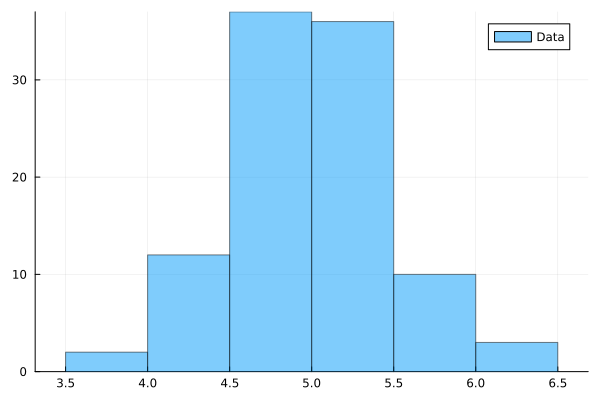

In [31]:
using Plots
histogram(Y, bins=10, alpha=0.5, label="Data")

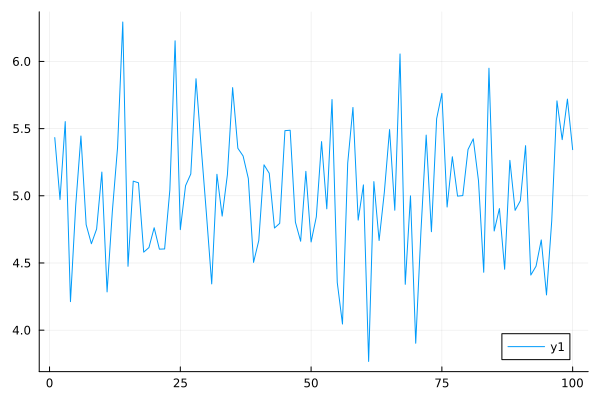

In [32]:
plot(Y)

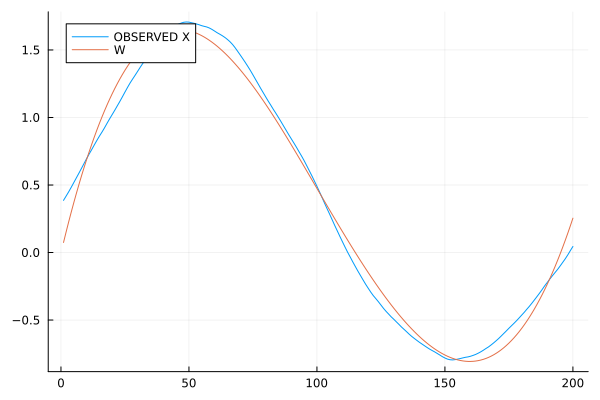

In [33]:
#  plot(U[1,1,:], label="TRUE U", legend=:topleft)
plot(X[1,1,:], label="OBSERVED X", legend=:topleft)
plot!(basis_values[1,:,:] * W[1, 1, :], label="W", legend=:topleft)


### Let's plot the data

The `plot_predictor_observations` function is used to plot the functional data for a specified predictor across multiple observations. It starts by plotting the first observation and then iteratively adds the remaining observations to the same plot. This function is useful for visualizing how a predictor behaves across different samples.
The `plot_transformed_W` function plots the matrix `W` after transforming it with the corresponding basis values. This is done for a specific predictor across multiple observations. The transformation involves a matrix multiplication of the basis values with the `W` matrix for each observation, which is then plotted. This visualization helps in understanding the effect of the basis transformation on the weights `W`.
Finally, the `plot_Z_observations` function plots the observations from the `Z` matrix for a given predictor. This is similar to the first function but applies to the `Z` matrix, which often contains the true or observed values before any transformation or modeling is applied.



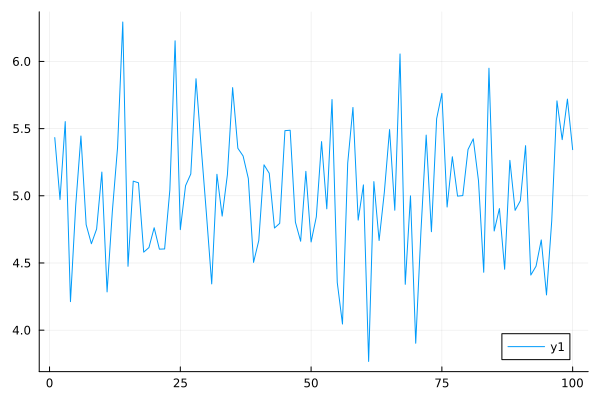

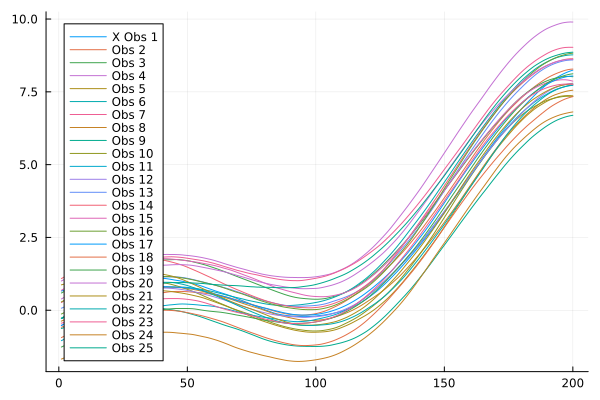

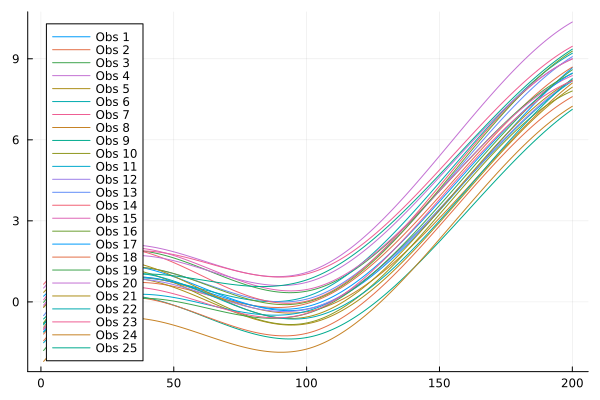

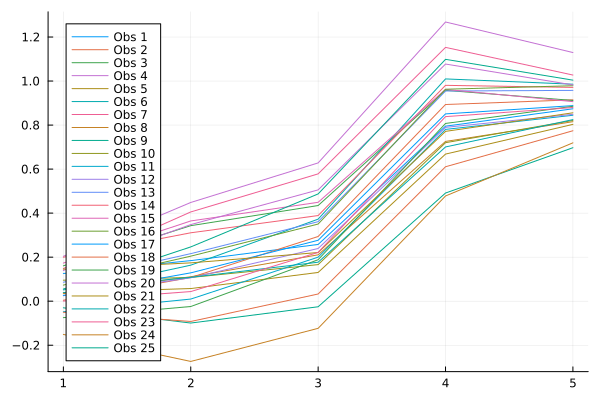

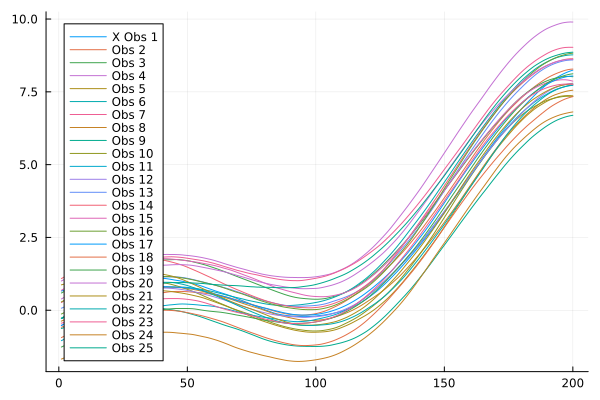

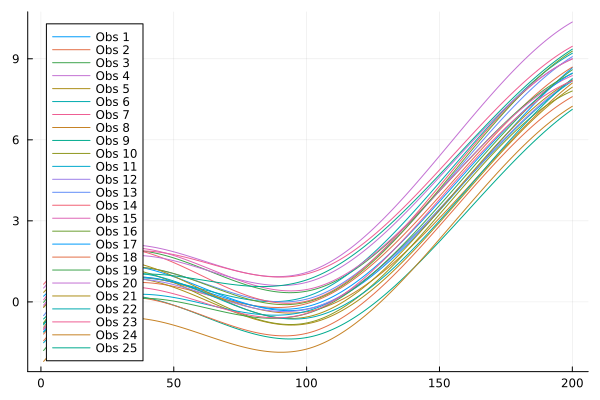

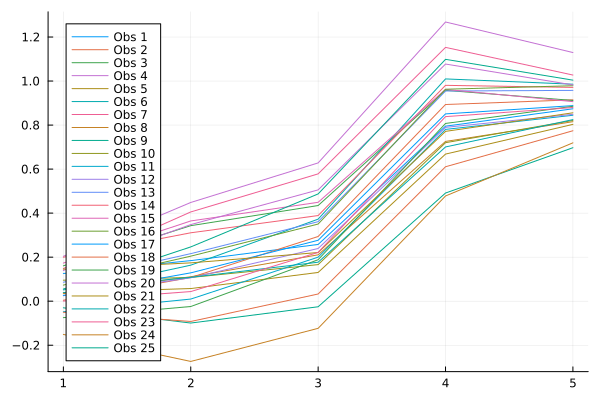

In [34]:
using Plots

# Function to plot multiple observations for a single predictor
function plot_predictor_observations(X, predictor, obs)
    p = plot(X[1, predictor, :], label = "X Obs 1")  # Start with the first observation
    for i in 2:obs
        plot!(p, X[i, predictor, :], label = "Obs $i")  # Add the rest
    end
    return p
end

# Function to plot the W matrix transformed by the basis values
function plot_transformed_W(basis_values, W, predictor, obs)
    p = plot(basis_values[predictor,:,:] * W[1, predictor, :], label = "Obs 1")  # Start with the first observation
    for i in 2:obs
        plot!(p, basis_values[predictor,:,:] * W[i, predictor, :], label = "Obs $i")  # Add the rest
    end
    return p
end

# Function to plot Z for multiple observations
function plot_Z_observations(Z, predictor, obs)
    p = plot(Z[1, predictor, :], label = "Obs 1")  # Start with the first observation
    for i in 2:obs
        plot!(p,  Z[i, predictor, :], label = "Obs $i")  # Add the rest
    end
    return p
end

# Initialize the plot for predictors
predictor = 2
obs = 25  # Limiting to the first 20 observations for clarity
pxxx= plot(Y)
display(pxxx)



# Plot the predictor for the first 20 observations over p0 (the previous plot)
p1 = plot_predictor_observations(X, predictor, obs)
display(p1)



# Plot the transformed W using the corresponding basis values for the first 20 observations
p2 = plot_transformed_W(basis_values, W, predictor, obs)
display(p2)

# Plot Z for the first 20 observations
p3 = plot_Z_observations(Z, predictor, obs)
display(p3)


# Plot the predictor for the first 20 observations
p11 = plot_predictor_observations(X_test, predictor, obs)
display(p11)

# Plot the transformed W using the corresponding basis values for the first 20 observations
p22 = plot_transformed_W(basis_values, W_test, predictor, obs)
display(p22)

# Plot Z for the first 20 observations
p33 = plot_Z_observations(Z_test, predictor, obs)
display(p33)


## Plotting the Y, Z, W, Basis
Visualize the processed input data to understand its distribution and structure before running the model.

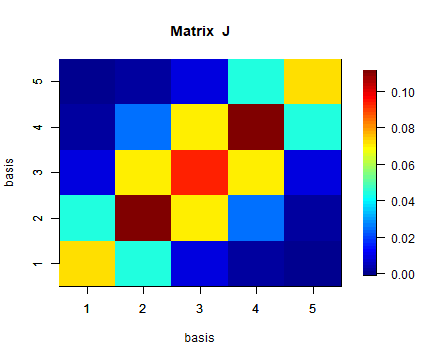

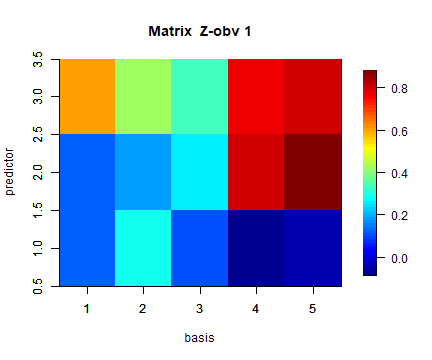

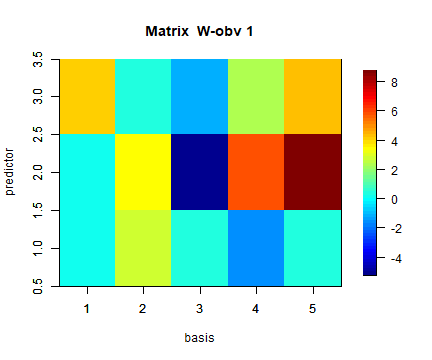

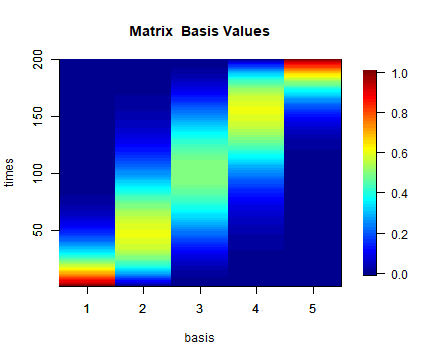

RObject{RealSxp}
[1] 1 2 3 4 5


In [35]:
using RCall

@rput J Z W basis_values
R"""
source(here("src", "R", "generic_simulator", "utils", "plot_utilities.R"))

plot_design_matrix(J[1,,], "J", "basis","basis")
#loop over the rows of Z in R code
for( i in 1:1 ) {
    plot_design_matrix(Z[i, ,], paste("Z-obv",i),"basis", "predictor")
    plot_design_matrix(W[i, ,], paste("W-obv",i),"basis", "predictor")
}
plot_design_matrix(basis_values[1,,], "Basis Values", "basis","times")

"""

## Model Execution
Run the predictive model using the prepared data.

In [36]:
i = 1
m = 1

W[i,m , :]'  * J[m, :, :] 


1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.123806  0.285262  0.111521  -0.0762008  -0.047934

In [37]:
#convert beta_matrix in a row vector
Z[i, m, :]'

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.123806  0.285262  0.111521  -0.0762008  -0.047934

In [38]:
i = 1
observations = Int(observations)
Z_ = zeros(observations)
for i in 1:observations

    Z_[i] = sum( Z[i,m,:]' * beta_matrix[m, :] for m in 1:Int(predictors) )
end
sum(Z_-Y)


-499.9799216391647

In [39]:
i = 56
Z_ = zeros(observations)
for i in 1:observations

    Z_[i] = sum( Z[i,m,:]' * beta_star[m, :] for m in 1:Int(predictors) )
end
sum(Z_-Y)


-500.01575752515475

In [40]:
model_name = "l0_limit.jl"
model_file_path = joinpath(project_root, "src", "Julia","models", model_name)

include(model_file_path)

λ = 0
λ_group = 0
M = 2

to_predict = sum(true_predictors)
beta_star, alpha_star, groups = mip_functional_regression(Y, Z, λ, λ_group, M; intercept = output[:intercept] != 0, group_limit= to_predict)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Set parameter TimeLimit to value 60
Set parameter Presolve to value 2
Set parameter Heuristics to value 0
Set parameter MIPGap to value 5e-06
Set parameter Threads to value 1
Set parameter NumericFocus to value 1
Set parameter NonConvex to value 2
Set parameter OptimalityTol to value 0.0001
Set parameter IntFeasTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter Threads to value 1
Set parameter TimeLimit to value 60
Set parameter NumericFocus to value 1
Set parameter Heuristics to value 0
Set parameter MIPGap to value 5e-06
Set parameter OptimalityTol to value 0.0001
Set parameter IntFeasTol to value 1e-09
Set parameter NonConvex to value 2
Set parameter Presolve to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 

([1.0020322731200777 0.9998920936356214 … 0.6851020481715733 0.5369524902049413; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 5.000157575251547, [1.0, -0.0, -0.0])

## Model Results
Display the results of the model, including the estimated beta coefficients.

In [41]:
beta_matrix # true beta

3×5 Matrix{Float64}:
 0.999926  1.00035  0.914667  0.680774  0.540258
 0.0       0.0      0.0       0.0       0.0
 0.0       0.0      0.0       0.0       0.0

In [42]:
beta_star  # estimated beta

3×5 Matrix{Float64}:
 1.00203  0.999892  0.911458  0.685102  0.536952
 0.0      0.0       0.0       0.0       0.0
 0.0      0.0       0.0       0.0       0.0

In [43]:
groups

3-element Vector{Float64}:
  1.0
 -0.0
 -0.0

In [44]:
alpha_star

5.000157575251547

## Hypothesis Testing in Functional Data Regression
Hypothesis testing in FDA is crucial for several reasons:
- **Understanding Individual Predictors**: It allows researchers to understand the influence of individual functional predictors on a scalar response, which is key in many applications like growth curves, weather patterns, and more.
- **Model Simplification**: By testing the significance of each predictor, it's possible to simplify the model by removing non-significant predictors, leading to more interpretable and efficient models.
- **Statistical Rigor**: Hypothesis testing adds a layer of statistical rigor, enabling researchers to make informed decisions about the inclusion or exclusion of predictors based on statistical evidence rather than intuition or heuristics.


## Conceptual Framework of Testing in FRM:
Testing individual functional predictors in a Functional Regression Model (FRM) is aimed at assessing their significance in predicting a scalar response. The typical null hypothesis \( H_0: b_r = 0 \) against the alternative \( H_a: b_r \neq 0 \) is a fundamental aspect of this process. This hypothesis testing framework is critical to distinguish predictors that have a meaningful impact on the response from those that do not.


- **Assumptions for Estimator Uniqueness**: A critical assumption in FRM is that the matrix \(Z\) should have fewer linearly independent columns than the number of observations (\(k < n\)). This ensures the existence and uniqueness of the least squares estimators, which is fundamental for the reliability of the regression model.
- **Residual Sum of Squares (RSS)**: RSS measures the discrepancy between the observed scalar responses and the responses predicted by the model. It is calculated as the sum of the squares of the residuals (the differences between observed and predicted values).

- **\(RSS_0\)**: This represents the Residual Sum of Squares for a reduced model where a particular functional predictor (and all its associated B-Spline coefficients) is excluded. Comparing \(RSS\) and \(RSS_0\) allows for testing the significance of the excluded predictor.

  

In [45]:
include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

function hypothesis_test(Y, Z, predictors, λ, λ_group, intercept, group_limit)
    test_stats = Dict()
    to_predict = sum(true_predictors)
    
    for r in 1:length(predictors)
        # Fit model under H0 (excluding the r-th predictor)
        Z_H0 = copy(Z)
        Z_H0[:, r, :] .= 0  # Set the r-th predictor coefficients to 0
        beta_star_H0, alpha_star_H0, _ = mip_functional_regression(Y, Z_H0, λ, λ_group, M; intercept = intercept, group_limit = group_limit)
        # Compute predictions and RSS0
        predictions_H0 = get_predictions(Z_H0, beta_star_H0, alpha_star_H0)
        RSS0 = sum((Y - predictions_H0).^2)

        # Fit model under Ha (including all predictors)
        beta_star_Ha, alpha_star_Ha, _ = mip_functional_regression(Y, Z, λ, λ_group, M; intercept = intercept, group_limit = group_limit)
        # Compute predictions and RSS
        predictions_Ha = get_predictions(Z, beta_star_Ha, alpha_star_Ha)
        RSS = sum((Y - predictions_Ha).^2)
        print(RSS,"__", RSS0)
        # Compute test statistic
        TL = (RSS0 - RSS) / var(Y)  # Assuming var(Y) as an estimate for σ²
        test_stats[r] = abs(TL)
    end

    test_stats
end

# Call the function
vectorized_predictors = collect(1:predictors)
test_results = hypothesis_test(Y, Z, vectorized_predictors, λ, λ_group, intercept != 0, to_predict)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Set parameter TimeLimit to value 60
Set parameter Presolve to value 2
Set parameter Heuristics to value 0
Set parameter MIPGap to value 5e-06
Set parameter Threads to value 1
Set parameter NumericFocus to value 1
Set parameter NonConvex to value 2
Set parameter OptimalityTol to value 0.0001
Set parameter IntFeasTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter Threads to value 1
Set parameter TimeLimit to value 60
Set parameter NumericFocus to value 1
Set parameter Heuristics to value 0
Set parameter MIPGap to value 5e-06
Set parameter OptimalityTol to value 0.0001
Set parameter IntFeasTol to value 1e-09
Set parameter NonConvex to value 2
Set parameter Presolve to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 

Dict{Any, Any} with 3 entries:
  2 => 0.0
  3 => 0.0
  1 => 96.4447

### Understanding the Distribution of the Test Statistic \( TL \)

#### The Chi-Square Distribution of \( TL \)

The test statistic \( TL \) in our hypothesis testing framework is crucial for determining the significance of each functional predictor in the model. Under certain assumptions, \( TL \) follows a chi-square distribution, specifically \( \chi^2_{k - k_0}(\delta) \). Here, \( k - k_0 \) are the degrees of freedom, and \( \delta \) is the non-centrality parameter. This distribution is pivotal for interpreting the test results accurately and for calculating the p-values, which are essential in statistical hypothesis testing.

#### Determining Key Quantities: \( K \), \( N \), and Degrees of Freedom

- **Role of \( K \) (Number of Coefficients)**: 
  - In our functional regression model, \( K \) represents the total number of coefficients. This includes all the coefficients associated with the B-Spline basis functions for our functional predictors. It's the dimensionality of our model, reflecting the complexity introduced by the predictors.

- **Role of \( N \) (Number of Observations)**: 
  - \( N \) signifies the total number of observations in our dataset. Each observation corresponds to a set comprising a functional predictor and its associated scalar response. The size of \( N \) is a key factor in determining the model's ability to estimate the parameters accurately and in assessing the statistical power of our tests.

- **Calculating Degrees of Freedom (DF)**:
  - Degrees of freedom, denoted as \( k - k_0 \), are calculated based on the difference in the number of estimated parameters under the full model (with all predictors) and the reduced model (under the null hypothesis, excluding specific predictors). This concept is central to understanding the distribution of \( TL \) and therefore to assessing the significance of each predictor in our model.

#### Using the Chi-Square Distribution for Statistical Inference

Understanding the chi-square distribution of \( TL \) allows us to derive p-values from our test statistics. These p-values are the probabilities of observing a test statistic as extreme as, or more extreme than, what we have observed, under the assumption that the null hypothesis is true. They are a cornerstone in making decisions about the statistical significance of our predictors. A low p-value (typically less than 0.05) suggests that the predictor has a significant impact on the response variable.

To derive these p-values, we compare the calculated \( TL \) statistic for each predictor against the chi-square distribution with \( k - k_0 \) degrees of freedom. This comparison will yield the probability (p-value) of obtaining a test statistic as extreme as the observed one under the null hypothesis.


In [46]:
# 
basis_functions = output[:basis_functions]
N = observations  
K = predictors * basis_functions
K_0 = K - basis_functions
DF = K - K_0 


5.0

To calculate \( N \), \( K \), and the degrees of freedom (DF):

1. **\( N \) (Number of Observations)**:
   - \( N \) is simply the sample size of our observations. Since we have direct access to the `observations` variable, \( N \) is equal to the size of this variable.

2. **\( K \) (Total Number of Coefficients in the Model)**:
   - To compute \( K \), we need to consider the number of basis functions used for each functional predictor and the total number of predictors.
   - If each of the `predictors` uses the same number of basis functions (denoted by `basis_functions`), then \( K \) can be calculated as the product of the number of predictors and the number of basis functions for each predictor.
   - However, if the number of basis functions varies across predictors, we would need to sum the number of basis functions for each predictor individually.

3. **\( k_0 \)** is the total number of coefficients in the model excluding the coefficients corresponding to the predictor being testedunder the null hypothesis \( H_0 \) of that specific predictor. 
   - If each predictor contributes an equal number of coefficients (say, every predictor uses the same number of basis functions), then \( k_0 \) remains constant across different null hypotheses, each testing a different predictor.
   - If the number of coefficients varies per predictor, \( k_0 \) will differ depending on which predictor's effect is being zeroed out in \( Z \).
1. **Degrees of Freedom (DF)**:
   - DF for the test statistic is calculated as \( k - k_0 \).

In [47]:
using Statistics
using Distributions

function compute_p_values(test_stats, df)
    p_values = Dict()
    
    for (predictor, TL) in test_stats
        # Calculate the p-value
        out = cdf(Chisq(df), TL)
        p_value = 1 - out
        p_values[predictor] = p_value
    end
    
    p_values
end

# Apply Bonferroni correction
function apply_bonferroni_correction(p_values, M)
    corrected_p_values = Dict()
    for (predictor, p_value) in p_values
        corrected_p_value = min(p_value * M, 1.0)  # Ensuring that p-values don't exceed 1
        corrected_p_values[predictor] = corrected_p_value
    end
    
    corrected_p_values
end

# Calculate p-values
p_values = compute_p_values(test_results, DF)  # Use k0_values dictionary

# Apply Bonferroni correction
bonferroni_corrected_p_values = apply_bonferroni_correction(p_values, length(predictors))
bonferroni_corrected_p_values

Dict{Any, Any} with 3 entries:
  2 => 1.0
  3 => 1.0
  1 => 0.0

In [48]:
function apply_fdr_correction(p_values, M, q)
    sorted_indices = sortperm(collect(p_values), by=x->x[2])
    adjusted_p_values = copy(p_values)
    
    # Start from the largest p-value, moving towards the smallest
    min_pval = 1.0
    for i in reverse(1:M)
        idx = sorted_indices[i]
        adjusted_p_value = min(p_values[idx] * M / i, min_pval)
        adjusted_p_values[idx] = adjusted_p_value
        min_pval = adjusted_p_value  # Ensure non-decreasing adjusted p-values
    end
    
    # Determine significance based on q
    significant_predictors = [key for (key, p_value) in adjusted_p_values if p_value <= q]

    return adjusted_p_values, significant_predictors
end
q = 0.005
fdr_corrected_p_values, significant_indices = apply_fdr_correction(p_values, length(predictors), q)
fdr_corrected_p_values

Dict{Any, Any} with 3 entries:
  2 => 1.0
  3 => 1.0
  1 => 0.0

In [49]:
# Define significance level
alpha = 0.05

# Identify significant predictors
significant_predictors = [predictor for (predictor, p_value) in bonferroni_corrected_p_values if p_value < alpha]

println("Significant predictors: ", significant_predictors)


Significant predictors: [1]


## Data Comparison
Compare the true beta matrix with the estimated beta matrix and calculate the percentage difference for each coefficient.

In [50]:
using DataFrames

# Ensure beta_matrix and beta_star have the same dimensions
if size(beta_matrix) != size(beta_star)
    error("beta_matrix and beta_star must have the same dimensions")
end

# Create a DataFrame and calculate the percentage error for each coefficient
df = DataFrame()
for i in 1:size(beta_matrix, 2)
    percent_error_col = Symbol("%_err_$i")

    # Replace values less than 10^-6 with zero in beta_matrix and beta_star
    beta_matrix[:, i] = ifelse.(abs.(beta_matrix[:, i]) .< 1e-6, 0, beta_matrix[:, i])
    beta_star[:, i] = ifelse.(abs.(beta_star[:, i]) .< 1e-6, 0, beta_star[:, i])

    # Calculate the percentage error while handling division by zero
    percent_error = ifelse.(beta_matrix[:, i] .== 0,
        ifelse.(beta_star[:, i] .== 0, 0, 100),
        round.(((beta_star[:, i] .- beta_matrix[:, i]) ./ beta_matrix[:, i]) .* 100, digits = 2)
    )
    # Convert the percentage error to a string with the percentage symbol, cap values over 500%
    df[!, percent_error_col] = ifelse.(percent_error .> 500.0, " >  500 %", string.(percent_error, " %"))
    df[!, percent_error_col] = ifelse.(percent_error .< -500.0, "< 500 %", df[!, percent_error_col])

end

# Show the DataFrame
display(df)

Row,%_err_1,%_err_2,%_err_3,%_err_4,%_err_5
,String,String,String,String,String
1,0.21 %,-0.05 %,-0.35 %,0.64 %,-0.61 %
2,0 %,0 %,0 %,0 %,0 %
3,0 %,0 %,0 %,0 %,0 %


## Evaluate Model Performance
Evaluate the model's performance using various metrics such as MSE, RMSE, MAE, and relative error.

In [51]:
using Statistics 
using LinearAlgebra

include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

performance_metrics = compute_metrics(Y_test, Z_test, beta_matrix, beta_star, alpha_star, groups, predictors)


[5.43313994004227, 4.97192752807049, 5.552186149761251, 4.212403800240572, 4.925985291690171, 5.444906701449868, 4.7850809355336565, 4.643192577081013, 4.752720702354051, 5.176665783781852, 4.284685722279056, 4.881280095998514, 5.358820986660343, 6.293342074491648, 4.475245855329373, 5.10917216487788, 5.09675507517357, 4.58059143724525, 4.614433851911131, 4.76230650767665, 4.602890716213776, 4.604424312645662, 5.043871025754242, 6.153346899226436, 4.748071913695259, 5.0750267496992745, 5.162230092456403, 5.871128964605645, 5.356912354945363, 4.860875131795234, 4.344251833336811, 5.160061733503841, 4.848747960446451, 5.156761246420196, 5.805043097725592, 5.353695748675191, 5.296333614881228, 5.129101712844151, 4.50446607506427, 4.667276847472639, 5.230560157369537, 5.167280336329265, 4.760003446109593, 4.795052368406684, 5.4847686854050925, 5.487902244502542, 4.803739517639984, 4.661691484382369, 5.182047818874501, 4.656319672828501, 4.843545662726564, 5.4032724771875795, 4.902991743282

Dict{String, Float64} with 11 entries:
  "Functional_Correlation" => 1.0
  "CDF_Distance"           => 1.99468e-5
  "R_squared"              => 1.0
  "RMSE_Predictions"       => 6.24454e-5
  "RMSE_Coefficients"      => 0.00172433
  "Area_Between_Curves"    => 0.00516313
  "ISE_Coefficients"       => 4.45998e-5
  "MSE_Predictions"        => 3.89943e-9
  "Adjusted_R_squared"     => 1.0
  "MSE_Coefficients"       => 2.97332e-6
  "MAE_Predictions"        => 5.16313e-5

## Prediction and Evaluation (FIX ME <-- compute real intervals)
Make predictions using the estimated coefficients and evaluate the model's accuracy.

In [52]:
using Statistics

# Evaluation of all metrics in the performance dictionary
function evaluate_all_metrics(performances, thresholds, higher_is_better)
    evaluations = Dict{String, String}()
    for (generic_name, metric_value) in performances
        if haskey(thresholds, generic_name)
            good_threshold, excellent_threshold = thresholds[generic_name]
            is_higher_better = get(higher_is_better, generic_name, false)
            evaluations[generic_name] = valuate_metric(metric_value, good_threshold, excellent_threshold, is_higher_better)
        end
    end
    return evaluations
end

# Method to evaluate a single metric
function valuate_metric(metric_value, good_threshold, excellent_threshold=nothing, higher_is_better=false)
    if isnothing(excellent_threshold)
        # Only a good threshold is provided
        if higher_is_better
            return metric_value >= good_threshold ? "Good" : "Poor"
        else
            return metric_value <= good_threshold ? "Good" : "Poor"
        end
    else
        # Both good and excellent thresholds are provided
        if higher_is_better
            if metric_value >= excellent_threshold
                return "Excellent"
            elseif metric_value >= good_threshold
                return "Good"
            else
                return "Poor"
            end
        else
            if metric_value <= excellent_threshold
                return "Excellent"
            elseif metric_value <= good_threshold
                return "Good"
            else
                return "Poor"
            end
        end
    end
end


# Define if higher values are better for each metric
higher_is_better = Dict(
    "MSE_Coefficients"       => false,
    "RMSE_Coefficients"      => false,
    "ISE_Coefficients"       => false,
    "MSE_Predictions"        => false,
    "RMSE_Predictions"       => false,
    "MAE_Predictions"        => false,
    "R_squared"              => true,
    "Adjusted_R_squared"     => true,
    "Functional_Correlation" => true,
    "CDF_Distance"           => false,
    "Area_Between_Curves"    => false
);




In [53]:
# Compute descriptive statistics for an array
function compute_stats(data)
    return Dict(
        "mean" => mean(data),
        "std" => std(data),
        "min" => minimum(data),
        "max" => maximum(data),
        "iqr" => quantile(data, 0.75) - quantile(data, 0.25)
    )
end

# Determine scaling thresholds based on the computed statistics
function determine_scaling_thresholds(beta_stats, prediction_stats)
    # Error-based metrics: Set thresholds based on standard deviation or IQR
    scaling_thresholds = Dict(
        "MSE_Coefficients" => (beta_stats["std"], beta_stats["std"] / 2),
        "RMSE_Coefficients" => (sqrt(beta_stats["std"]), sqrt(beta_stats["std"] / 2)),
        "ISE_Coefficients" => (beta_stats["iqr"], beta_stats["iqr"] / 2),
        "MSE_Predictions" => (prediction_stats["std"], prediction_stats["std"] / 2),
        "RMSE_Predictions" => (sqrt(prediction_stats["std"]), sqrt(prediction_stats["std"] / 2)),
        "MAE_Predictions" => (prediction_stats["iqr"], prediction_stats["iqr"] / 2),
        "R_squared" => (0.5, 0.7),  # Static thresholds
        "Adjusted_R_squared" => (0.5, 0.7),  # Static thresholds
        "Functional_Correlation" => (0.3, 0.5),  # Got to figure out what to use here
        "CDF_Distance" => (prediction_stats["iqr"], prediction_stats["iqr"] / 2),  # ????
        "Area_Between_Curves" => (prediction_stats["iqr"], prediction_stats["iqr"] / 2)  # ???
    )
    return scaling_thresholds
end

# Assuming you have computed your beta_matrix, beta_star, and predictions
# Compute stats for beta coefficients and predictions
beta_stats = compute_stats(reshape(beta_matrix, :))
prediction_stats = compute_stats(reshape(Y_test, :))  # Assuming Y_test contains predictions

# Determine scaling thresholds
scaling_thresholds = determine_scaling_thresholds(beta_stats, prediction_stats)

# Print thresholds
print("Scaling Thresholds: ", scaling_thresholds)


Scaling Thresholds: Dict("Functional_Correlation" => (0.3, 0.5), "CDF_Distance" => (0.6370812871059659, 0.31854064355298295), "R_squared" => (0.5, 0.7), "RMSE_Predictions" => (0.6958757783206272, 0.49205848171398214), "RMSE_Coefficients" => (0.6469218127084091, 0.4574428006636097), "Area_Between_Curves" => (0.6370812871059659, 0.31854064355298295), "ISE_Coefficients" => (0.6105162678516481, 0.30525813392582407), "MSE_Predictions" => (0.4842430988533386, 0.2421215494266693), "Adjusted_R_squared" => (0.5, 0.7), "MSE_Coefficients" => (0.4185078317579339, 0.20925391587896694), "MAE_Predictions" => (0.6370812871059659, 0.31854064355298295))

In [54]:
# Perform evaluations
evaluations = evaluate_all_metrics(performance_metrics, scaling_thresholds, higher_is_better)

# Display evaluations
for (metric, evaluation) in evaluations
    metric_value = performance_metrics[metric]
    metric_range = scaling_thresholds[metric]
    println("$metric: $evaluation, Value: $metric_value, Range: $metric_range")
end

Functional_Correlation: Excellent, Value: 0.9999999916013622, Range: (0.3, 0.5)
CDF_Distance: Excellent, Value: 1.9946810503036067e-5, Range: (0.6370812871059659, 0.31854064355298295)
RMSE_Predictions: Excellent, Value: 6.244540142547358e-5, Range: (0.6958757783206272, 0.49205848171398214)
RMSE_Coefficients: Excellent, Value: 0.0017243323057384492, Range: (0.6469218127084091, 0.4574428006636097)
Area_Between_Curves: Excellent, Value: 0.005163128906020997, Range: (0.6370812871059659, 0.31854064355298295)
ISE_Coefficients: Excellent, Value: 4.459982850919915e-5, Range: (0.6105162678516481, 0.30525813392582407)
Adjusted_R_squared: Excellent, Value: 0.9999999826778094, Range: (0.5, 0.7)
MAE_Predictions: Excellent, Value: 5.163128906020997e-5, Range: (0.6370812871059659, 0.31854064355298295)
R_squared: Excellent, Value: 0.9999999832027243, Range: (0.5, 0.7)
MSE_Predictions: Excellent, Value: 3.899428159188538e-9, Range: (0.4842430988533386, 0.2421215494266693)
MSE_Coefficients: Excellent, V

## Residual Analysis
Analyze the residuals from the model to check for any patterns that might suggest issues with the model.

In [61]:
adjusted_r_squared(Y_test,Y_pred,predictors)

[5.43313994004227, 4.97192752807049, 5.552186149761251, 4.212403800240572, 4.925985291690171, 5.444906701449868, 4.7850809355336565, 4.643192577081013, 4.752720702354051, 5.176665783781852, 4.284685722279056, 4.881280095998514, 5.358820986660343, 6.293342074491648, 4.475245855329373, 5.10917216487788, 5.09675507517357, 4.58059143724525, 4.614433851911131, 4.76230650767665, 4.602890716213776, 4.604424312645662, 5.043871025754242, 6.153346899226436, 4.748071913695259, 5.0750267496992745, 5.162230092456403, 5.871128964605645, 5.356912354945363, 4.860875131795234, 4.344251833336811, 5.160061733503841, 4.848747960446451, 5.156761246420196, 5.805043097725592, 5.353695748675191, 5.296333614881228, 5.129101712844151, 4.50446607506427, 4.667276847472639, 5.230560157369537, 5.167280336329265, 4.760003446109593, 4.795052368406684, 5.4847686854050925, 5.487902244502542, 4.803739517639984, 4.661691484382369, 5.182047818874501, 4.656319672828501, 4.843545662726564, 5.4032724771875795, 4.902991743282

0.9999999826778094

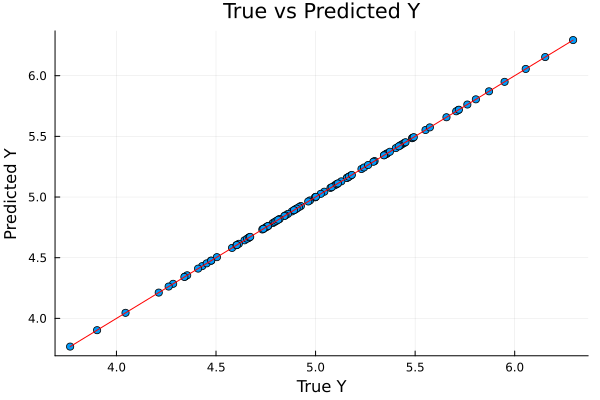

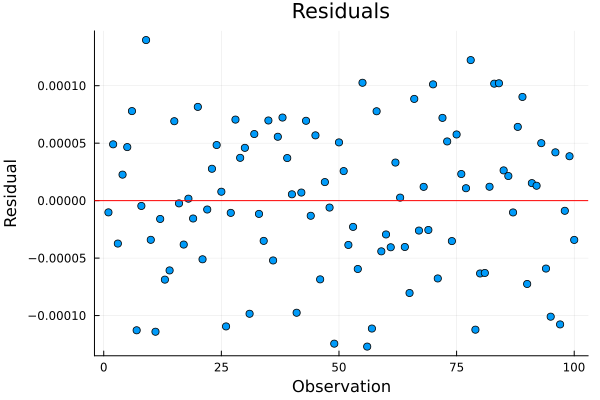

In [55]:
using Plots

Y_pred = get_predictions(Z_test, beta_star, alpha_star)
# 1. Scatter plot comparing true vs predicted values
scatter(Y_test, Y_pred, xlabel="True Y", ylabel="Predicted Y", legend=false, title="True vs Predicted Y")
plot!(Y_test, Y_test, color=:red)  # A y=x line for reference
display(plot!())

# 2. Plot residuals
residuals = Y_test - Y_pred
scatter(1:observations, residuals, xlabel="Observation", ylabel="Residual", legend=false, title="Residuals")
hline!([0], color=:red, label="Zero line")
display(plot!())


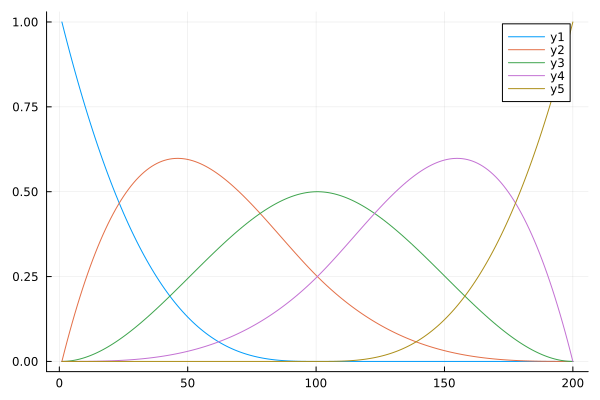

In [56]:
pbasis_values =basis_values
plot( pbasis_values[1,:,1])
plot!(pbasis_values[1,:,2])
plot!(pbasis_values[1,:,3])
plot!(pbasis_values[1,:,4])
plot!(pbasis_values[1,:,5])


## Final Output
Plot the combined predicted curve and save the output for further analysis.

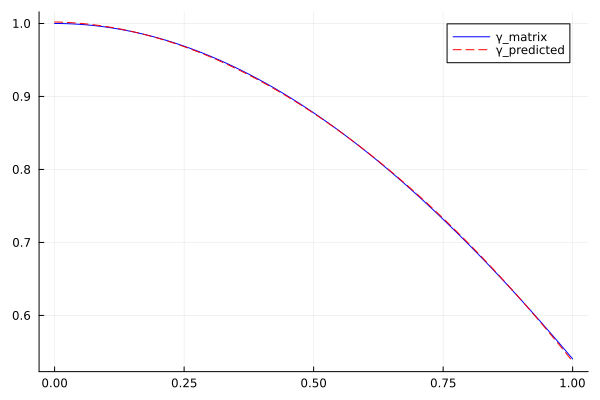

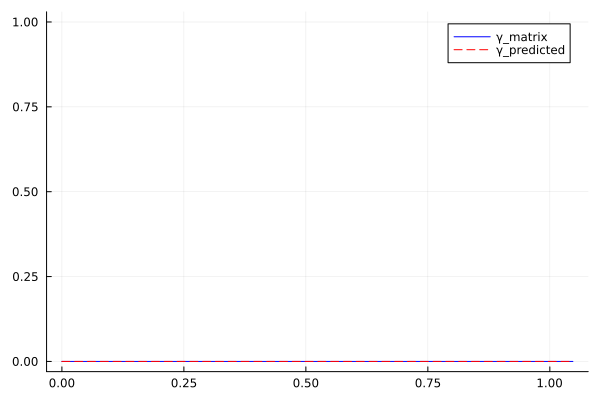

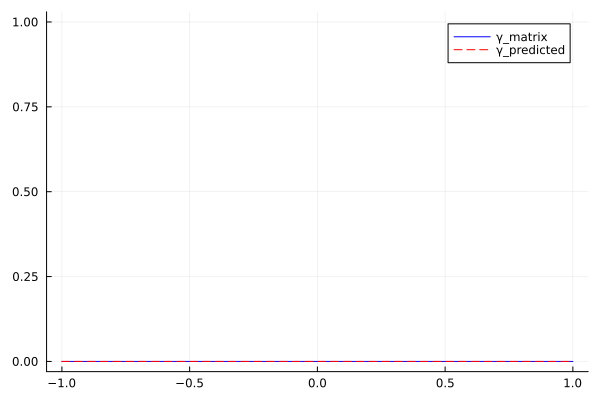

In [57]:
project_root = dirname( dirname(@__DIR__))
plot_file_path = joinpath(project_root, "src", "Julia","utils", "plot.jl")

include(plot_file_path)

output_folder= joinpath(project_root, "outputs", "plots", simulation_name)

beta_point_values = output[:beta_point_values]
plot_combined_predicted_curve(beta_point_values, beta_star,basis_values, time_domains,output_folder, true)


In [58]:
# beta_matrix = output[:B]
# predictor = 4
# y =basis_values[predictor,:,:] * beta_matrix[predictor,:];

# plot(time_domains[predictor], y, label="APPROX")
# # apply the sin(t) function to all the elements in time_domains[1,:]
# y2 = Array{Float64}(undef, size(y))
# for i in 1:length(y)
#     y2[i] = sinccoutput[:beta_funcs]()
# end
# # plot the line y = sin(t) on the same plot
# plot!(time_domains[predictor], y2, label="TRUE")
# display(plot!())
